# 이미지 하나에 대한 이진화 작업

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_fingerprint(image_path):
    # Load the fingerprint image
    fingerprint_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Normalize histogram
    normalized_img = cv2.normalize(fingerprint_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Apply histogram equalization to enhance contrast
    equalized_img = cv2.equalizeHist(normalized_img)

    # Apply to smooth the image
    blurred_img = cv2.GaussianBlur(equalized_img, (9, 9), 0)
    # blurred_img = cv2.medianBlur(equalized_img, 7)

    # Apply adaptive thresholding to binarize the image
    binarized_img = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # 이진화를 해도 노이즈가 남아있을 수 있으니 smoothen
    final_img = cv2.medianBlur(blurred_img, 7)

    return binarized_img


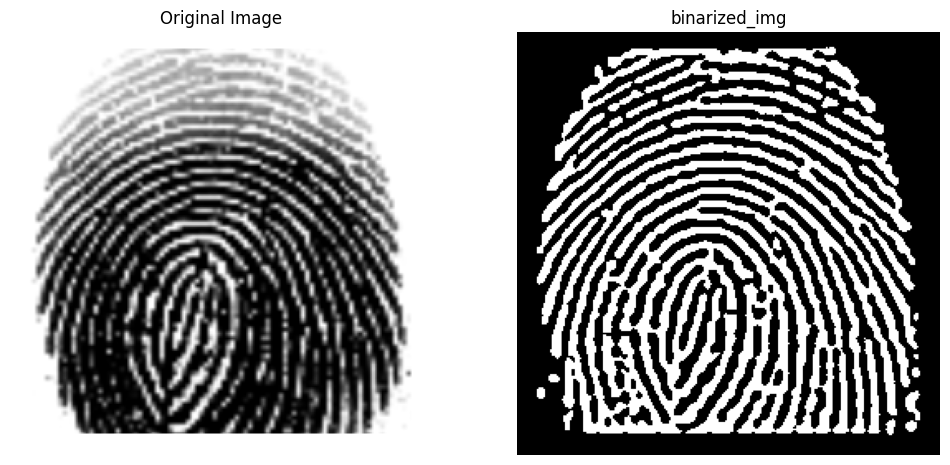

In [ ]:
# Example usage:
image_path = '/content/drive/MyDrive/biosec/train_ref/1.BMP'
binarized_img = preprocess_fingerprint(image_path)

# Display the original and preprocessed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# binarized_img
ax[1].imshow(binarized_img, cmap='gray')
ax[1].set_title('binarized_img')
ax[1].axis('off')

plt.show()


# 이진화 이미지에 대한 segmentation mask 추출

-> cv2.MORPH_CLOSE하고 cv2.findContours() 이용해서 외곽선 좌표 추출

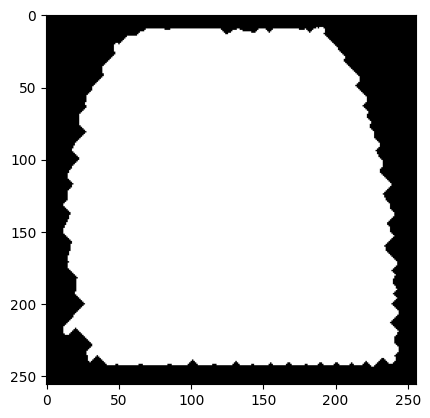

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
img_morph = cv2.morphologyEx(binarized_img, cv2.MORPH_OPEN, kernel, iterations=1)
img_morph = cv2.morphologyEx(img_morph, cv2.MORPH_CLOSE, kernel, iterations=7)

plt.imshow(img_morph, cmap='gray')

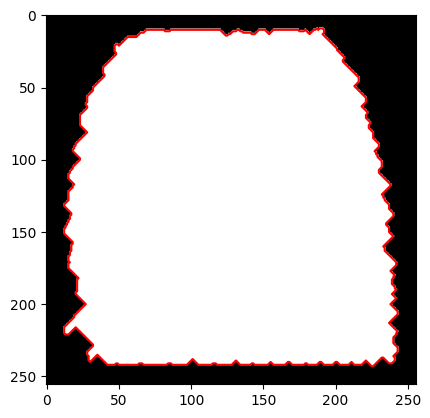

In [ ]:
contours, _ = cv2.findContours(img_morph.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 이미지 표시
plt.imshow(img_morph, cmap='gray')

# 각 윤곽선 그리기
for contour in contours:
    x = [point[0][0] for point in contour]  # 윤곽선의 x 좌표들
    y = [point[0][1] for point in contour]  # 윤곽선의 y 좌표들
    plt.plot(x, y, color='red')  # 윤곽선 그리기

plt.show()

In [ ]:
def create_mask(binarized_img):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  img_morph = cv2.morphologyEx(binarized_img, cv2.MORPH_OPEN, kernel, iterations=1)
  img_morph = cv2.morphologyEx(img_morph, cv2.MORPH_CLOSE, kernel, iterations=7)

  return img_morph

def create_contour(img_morph):
  contours, _ = cv2.findContours(img_morph.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  return contours

# 이미지 하나에 대한 세선화 작업

In [ ]:
from skimage.morphology import skeletonize
from skimage.morphology import thin

def skeleton(image):
    # 스켈레톤화
    skeleton = skeletonize(image // 150)

    # Convert skeletonized image to grayscale
    skeleton = (skeleton * 255).astype(np.uint8)

    final_img = cv2.medianBlur(skeleton, 7)

    return skeleton


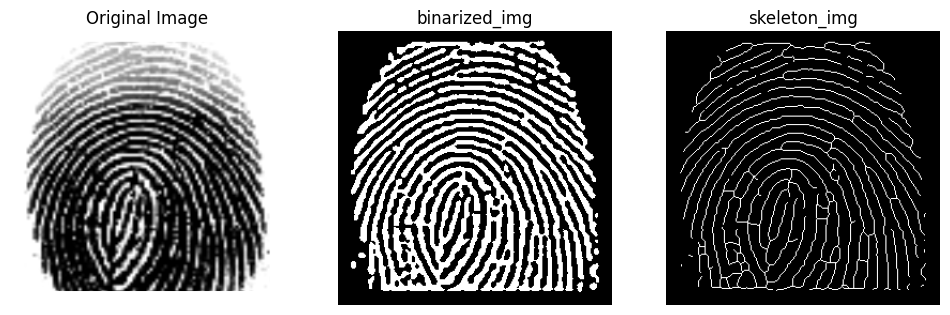

In [ ]:
skeleton_img = skeleton(binarized_img)

# Display the original and preprocessed images
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Original Image
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# binarized_img
ax[1].imshow(binarized_img, cmap='gray')
ax[1].set_title('binarized_img')
ax[1].axis('off')

# skeleton_img
ax[2].imshow(skeleton_img, cmap='gray')
ax[2].set_title('skeleton_img')
ax[2].axis('off')

plt.show()

# 이미지 하나에 대한 특징 추출

## 끝점 처리 전

In [ ]:
def minutiae_extraction(thinned_image):
    minutiae_endings = []
    minutiae_bifurcations = []
    rows, cols = thinned_image.shape

    # 3x3 윈도우를 사용하여 이미지의 각 픽셀을 검사
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # 픽셀이 흰색(255)인지 확인
            if thinned_image[i, j] == 255:
                # 3x3 윈도우 내의 픽셀들을 검사하여 끝점인지 분기점인지 판단
                window = thinned_image[i-1:i+2, j-1:j+2]
                if np.sum(window)==255*2:
                   # 자기 자신을 제외한 이웃 중 흰색인 픽셀 수
                    minutiae_endings.append((j, i))
                elif np.sum(window)==255*4:
                    minutiae_bifurcations.append((j, i))

    return minutiae_endings, minutiae_bifurcations




def draw_minutiae(image, minutiae_endings, minutiae_bifurcations):
    # Convert grayscale image to RGB
    image_with_minutiae = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Draw endings as red 'x'
    for ending in minutiae_endings:
        cv2.drawMarker(image_with_minutiae, ending, (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1, line_type=cv2.LINE_AA)

    # Draw bifurcations as green '+'
    for bifurcation in minutiae_bifurcations:
        cv2.drawMarker(image_with_minutiae, bifurcation, (0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1, line_type=cv2.LINE_AA)

    return image_with_minutiae


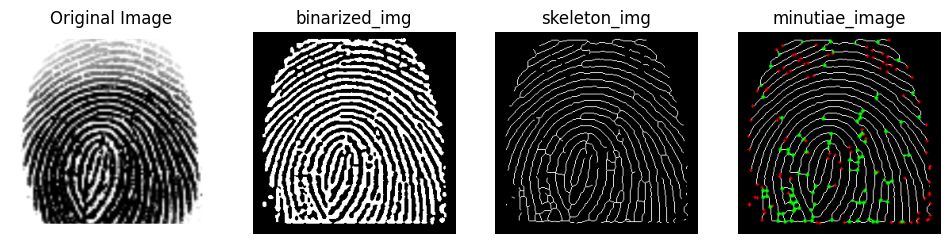

In [ ]:
min_end, min_bif = minutiae_extraction(skeleton_img)
minutiae_image = draw_minutiae(skeleton_img, min_end, min_bif)

# Display the original and preprocessed images
fig, ax = plt.subplots(1, 4, figsize=(12, 6))

# Original Image
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# binarized_img
ax[1].imshow(binarized_img, cmap='gray')
ax[1].set_title('binarized_img')
ax[1].axis('off')

# skeleton_img
ax[2].imshow(skeleton_img, cmap='gray')
ax[2].set_title('skeleton_img')
ax[2].axis('off')

# minutiae_image
ax[3].imshow(minutiae_image)
ax[3].set_title('minutiae_image')
ax[3].axis('off')

plt.show()

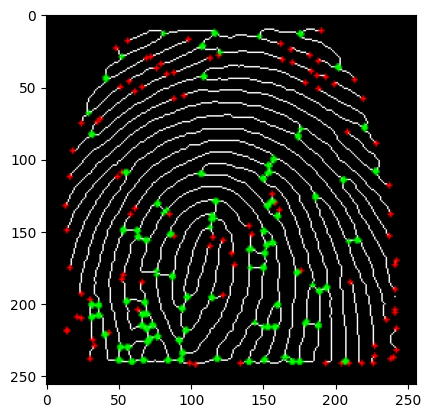

In [ ]:
plt.imshow(minutiae_image)

In [ ]:
plt.close()

## 끝점 처리 후

mask로 만든 거 이용

In [ ]:
def remove_endpoints(min, contours):
    # 컨투어에서 각각의 점 추출
    tuple_contours = [tuple(point.squeeze().tolist()) for contour in contours for point in contour]

    # 중복 제거를 위해 새로운 미누티아 리스트 생성
    true_min = []

    # 각 미누티아의 위치가 컨투어와 겹치는지 확인하고 중복 제거
    for point in min:
        # 컨투어와 중복되지 않는 좌표 확인
        unique = True
        for contour_point in tuple_contours:
            if abs(point[0] - contour_point[0]) < 5 and abs(point[1] - contour_point[1]) < 5:
                unique = False
                break

        # 중복되지 않는 경우만 추가
        if unique:
            true_min.append(point)

    return true_min


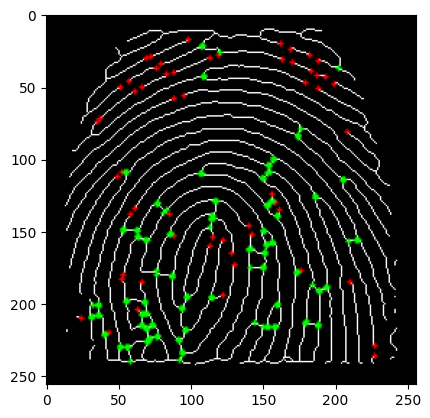

In [ ]:
true_bif_end = remove_endpoints(min_bif, contours)
true_min_end = remove_endpoints(min_end, contours)

end_removed_image = draw_minutiae(skeleton_img, true_min_end, true_bif_end)
plt.imshow(end_removed_image)

# 최종 전처리 함수

In [ ]:
def preprocess(image_path, pltshow):
    binarized_img = preprocess_fingerprint(image_path)
    morphed_img = create_mask(binarized_img)
    contours = create_contour(morphed_img)
    skeletoned_img = skeleton(binarized_img)
    min_end, min_bif = minutiae_extraction(skeletoned_img)
    true_min_end = remove_endpoints(min_end, contours)
    true_min_bif = remove_endpoints(min_bif, contours)


    if(pltshow == True):
        minutiae_image = draw_minutiae(skeletoned_img, true_min_end, true_min_bif)

        # Display the original and preprocessed images
        fig, ax = plt.subplots(1, 4, figsize=(12, 6))

        # Original Image
        original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        ax[0].imshow(original_img, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        # binarized_img
        ax[1].imshow(binarized_img, cmap='gray')
        ax[1].set_title('binarized_img')
        ax[1].axis('off')

        # skeletoned_img
        ax[2].imshow(skeletoned_img, cmap='gray')
        ax[2].set_title('skeletoned_img')
        ax[2].axis('off')

        # minutiae_image
        ax[3].imshow(minutiae_image, cmap='gray')
        ax[3].set_title('minutiae_image')
        ax[3].axis('off')

        plt.show()

        return true_min_end, true_min_bif, minutiae_image

    return true_min_end, true_min_bif

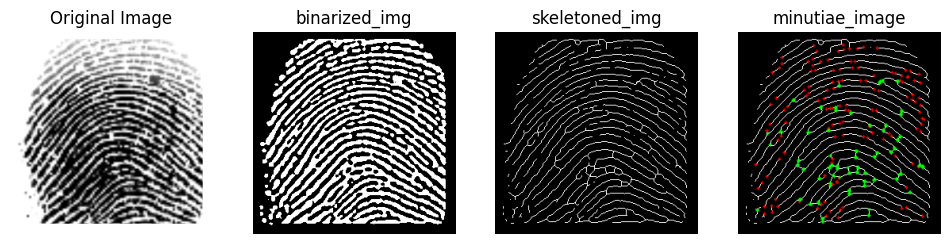

In [ ]:
min_end, min_bif, _ = preprocess('/content/drive/MyDrive/biosec/train_ref/104.BMP', True)

# matching

In [ ]:
def match_finger(feat_query, feat_train, threshold, pltshow, img_query=None, img_train=None):
    # Convert features to float32 for FLANN
    feat_query = np.float32(feat_query)
    feat_train = np.float32(feat_train)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(feat_query, feat_train, k=2)

    # matches 중에 threshold를 정해서 더 가까운 match(good matches)들만 뽑아냄
    good_matches = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)

    num_matches = len(good_matches)
    matching_score = num_matches / ((len(feat_query)+ len(feat_train))/2) * 100

    if pltshow:
        img_matches = cv2.drawMatches(img_query, [cv2.KeyPoint(p[0], p[1], 1) for p in feat_query],
                                      img_train, [cv2.KeyPoint(p[0], p[1], 1) for p in feat_train],
                                      good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        plt.imshow(img_matches)
        plt.show()

    return num_matches, matching_score, good_matches


def matching_start(train_path, test_path, threshold, pltshow):
    # Read images
    img_train = cv2.imread(train_path, cv2.IMREAD_GRAYSCALE)
    img_test = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess and extract features
    q_end, q_bif = preprocess(test_path, pltshow=False)
    db_end, db_bif = preprocess(train_path, pltshow=False)

    feat_query = np.concatenate([q_end, q_bif])
    feat_train = np.concatenate([db_end, db_bif])


    # # Match features
    num_matches, matching_score, matches = match_finger(feat_query, feat_train, threshold, pltshow, img_query=img_test, img_train=img_train)
    print(f'Matching Score: {matching_score}, Number of Matches: {num_matches}')

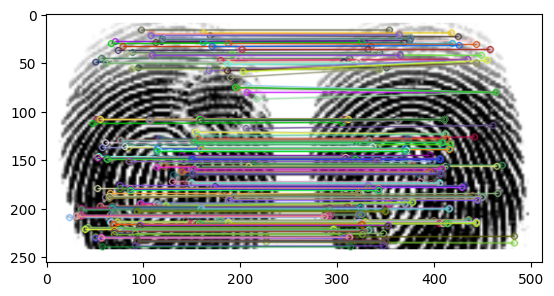

Matching Score: 83.89380530973452, Number of Matches: 237


In [ ]:
train_1 = '/content/drive/MyDrive/biosec/train_ref/1.BMP'
test_1 = '/content/drive/MyDrive/biosec/test2/1_type1.BMP'

matching_start(train_1, test_1, 0.8, True)

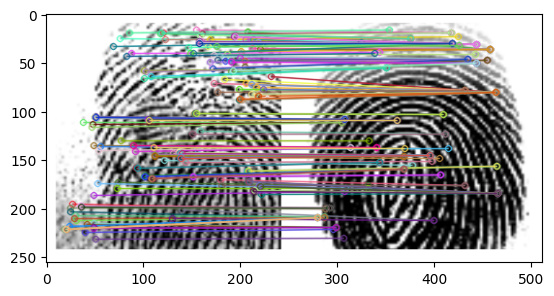

Matching Score: 40.3041825095057, Number of Matches: 159


In [ ]:
train_1 = '/content/drive/MyDrive/biosec/train_ref/1.BMP'
test_10 = '/content/drive/MyDrive/biosec/test2/10_type1.BMP'

matching_start(train_1, test_10, 0.8, True)

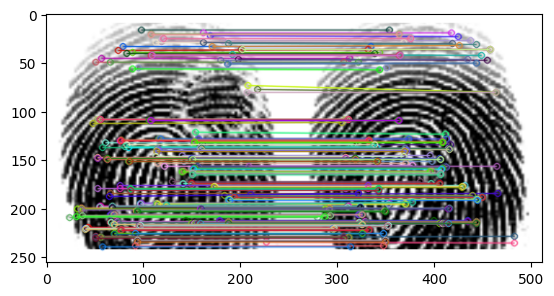

Matching Score: 70.08849557522124, Number of Matches: 198


In [ ]:
matching_start(train_1, test_1, 0.4, True)

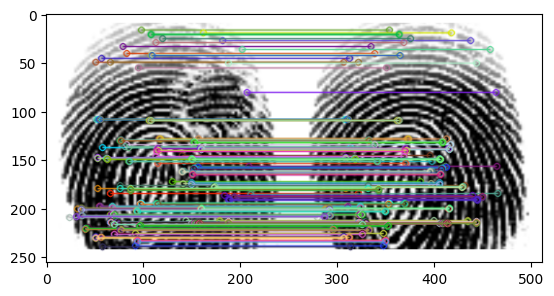

Matching Score: 61.59292035398231, Number of Matches: 174


In [ ]:
matching_start(train_1, test_1, 0.1, True)

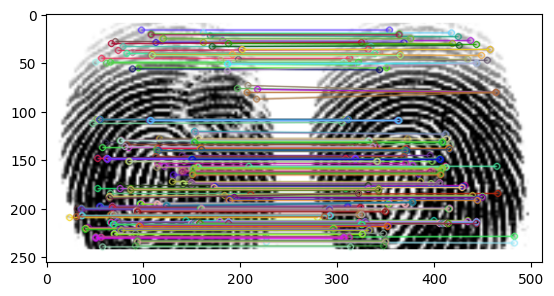

Matching Score: 74.69026548672566, Number of Matches: 211


In [ ]:
matching_start(train_1, test_1, 0.6, True)

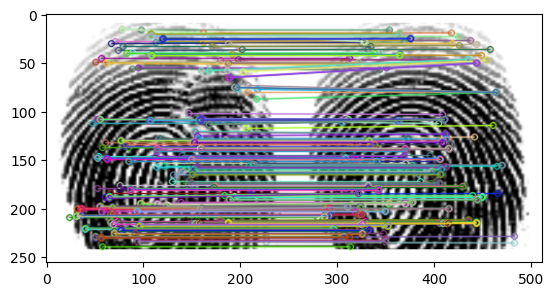

Matching Score: 89.20353982300885, Number of Matches: 252


In [ ]:
matching_start(train_1, test_1, 0.9, True)

# fingerprint 이미지 전체에 대해서 전처리 후 output 저장

In [ ]:
from os.path import join
from glob import glob
from tqdm.notebook import tqdm

all_train_path = '/content/drive/MyDrive/biosec/train_ref/'
all_test2_path = '/content/drive/MyDrive/biosec/test2'

list_train = sorted(glob(join(all_train_path, '*.BMP')))
list_test2 = sorted(glob(join(all_test2_path, '*.BMP')))

In [ ]:
def extract_features(image_paths):
    features = {}
    for image_path in tqdm(image_paths):
        end_points, bif_points = preprocess(image_path, pltshow=False)
        features[image_path] = np.concatenate([end_points, bif_points])
    return features

In [ ]:
# Extract and save features
train_features = extract_features(list_train)
test_features = extract_features(list_test2)

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

In [ ]:
def find_top_matches(train_features, test_features):
    match_results = []
    for test_path, feat_query in tqdm(test_features.items(), desc="Matching Progress"):
        results = []
        for train_path, feat_train in train_features.items():
            num_matches, similarity, good_matches = match_finger(feat_query, feat_train, 0.7, False)
            results.append((train_path, similarity, num_matches))

        # Sort the results by similarity in descending order and get the top N
        results.sort(key=lambda x: x[1], reverse=True)
        top_matches = results[:1]
        match_results.append([test_path, top_matches])

        print(f'Top 1 matches for {test_path}:')
        for match in top_matches:
            print(f'Train Path: {match[0]}, Similarity: {match[1]}, Number of Matches: {match[2]}')

    return match_results

In [ ]:
match_results = find_top_matches(train_features, test_features)

Matching Progress:   0%|          | 0/1428 [00:00<?, ?it/s]

Top 1 matches for /content/drive/MyDrive/biosec/test2/100_type1.BMP:
Train Path: /content/drive/MyDrive/biosec/train_ref/100.BMP, Similarity: 88.84540117416829, Number of Matches: 227
Top 1 matches for /content/drive/MyDrive/biosec/test2/100_type2.BMP:
Train Path: /content/drive/MyDrive/biosec/train_ref/100.BMP, Similarity: 83.24324324324324, Number of Matches: 231
Top 1 matches for /content/drive/MyDrive/biosec/test2/100_type3.BMP:
Train Path: /content/drive/MyDrive/biosec/train_ref/100.BMP, Similarity: 88.75968992248062, Number of Matches: 229
Top 1 matches for /content/drive/MyDrive/biosec/test2/101_type1.BMP:
Train Path: /content/drive/MyDrive/biosec/train_ref/101.BMP, Similarity: 61.89624329159212, Number of Matches: 173
Top 1 matches for /content/drive/MyDrive/biosec/test2/101_type2.BMP:
Train Path: /content/drive/MyDrive/biosec/train_ref/101.BMP, Similarity: 73.07692307692307, Number of Matches: 209
Top 1 matches for /content/drive/MyDrive/biosec/test2/101_type3.BMP:
Train Path:

# Metric 계산

In [ ]:
def calculate_metrics(tp, fp, tn, fn):
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn > 0 else 0
    far = fp / (fp + tn) if fp + tn > 0 else 0
    frr = fn / (fn + tp) if fn + tp > 0 else 0
    return precision, recall, accuracy, far, frr

In [ ]:
def evaluate_matching(match_results):
    tp, fp, tn, fn = 0, 0, 0, 0

    for test_path, matches in match_results:
        test_id = os.path.basename(test_path).split('_')[0]  # Extract test ID

        top_match = matches[0][0]  # Get the top match (train path)
        train_id = os.path.basename(top_match).split('.')[0]  # Extract train ID

        if test_id == train_id:
            tp += 1
        else:
            fp += 1

    # Calculate false negatives and true negatives
    total_tests = len(match_results)
    total_trains = len(train_features)

    fn = total_tests - tp
    tn = total_trains - fp

    precision, recall, accuracy, far, frr = calculate_metrics(tp, fp, tn, fn)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'FAR: {far:.4f}')
    print(f'FRR: {frr:.4f}')


In [ ]:
# Evaluate the matching
evaluate_matching(match_results)

Precision: 0.9650
Recall: 0.9650
Accuracy: 0.9475
FAR: 0.1048
FRR: 0.0350
